# AutoEncoders

Roland Kwitt     
University of Salzburg (2019)

---

In this lecture, we we build our first simple **autoencoder** (for MNIST images), i.e., a popular technique for unsupervised representation learning, implementing a mapping

$$ f_{\theta} \circ g_{\phi}: \mathbb{R}^d \to \mathbb{R}^d$$

Here, we refer to $g_{\phi}: \mathbb{R}^d \to Z$ as an *encoder* and to $f_{\theta}: \mathbb{R}^l \to Z$ as a *decoder*. In general, we have $Z \subset \mathbb{R}^l$ and we
call $Z$ the *representation space* (or *latent* space).

In general, we train autoencoders to *reconstruct* the input, e.g., by measuring the mean-squared error of the difference between the input and the output. There is no supervisory signal as in supervised learning (e.g., the class labels). 

Below is a conceptual illustration of the basic architecture.

![Bottleneck](AutoEncLecture.png "AutoEncoder")

In [1]:
%matplotlib inline

import torch
import torch.utils.data

from torch import nn
from torch import optim
from torch.nn import functional as F

from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

First, we create our data loaders ...

In [3]:

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data_mnist/', 
                   train=True, 
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data_mnist', 
                   train=False, 
                   transform=transforms.ToTensor()),
    batch_size=128, 
    shuffle=True)

Next, we define our autoencoder model. In particular, inputs will be of size $28 \times 28$ as our MNIST images are binary images of that spatial size. 

We will flatten the images and just use linear layers with ReLU activations for now. Later, we will refine this model to implement a *convolutional autoencoder*.

In [25]:
class AutoEnc(nn.Module):
    def __init__(self):
        super(AutoEnc, self).__init__()

        # Define our linear layers, latent representation dim. is 20 here!
        self.fc1  = nn.Linear(784, 400)
        self.fc2  = nn.Linear(400, 2)
        self.fc3  = nn.Linear(2, 400)
        self.fc4  = nn.Linear(400, 784)
        
    # implement the encoder (Lin.->ReLU->Lin.)
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2(h1)

    # implement the decoder (Lin.->ReLU->Sigmoid)
    # we use a sigmoid at the end, as we want outputs in [0,1]
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # implement the forward pass, i.e., encoder->decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784)) # 28*28=784
        return z, self.decode(z)

We can now instantiate that model, define an optimizer and write our train and test routines.

In [30]:
model = AutoEnc().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x):
    """
    As loss, we use binary cross entropy - remember our inputs are in {0,1}
    and the output of the autoencoder model is in [0,1], so this is a valid
    choice; reduction='sum' means that the reconstruction loss is not averaged,
    but just summed up!
    """
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    return BCE


def train(epoch):
    model.train()
    
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        
        data = data.to(device)
        
        # reset gradients to 0
        optimizer.zero_grad()
        
        # forward batch of data through model
        _, recon_batch = model(data)
        
        # compute reconstruction loss
        loss = loss_function(recon_batch, data)
        
        # compute gradients 
        loss.backward()
        
        train_loss += loss.item()
        
        # take an optimizer step
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            _, recon_batch = model(data)
            test_loss += loss_function(recon_batch, data).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [31]:
n_epochs = 10
for epoch in range(1, n_epochs+1):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 542.309692
Train Epoch: 1 [12800/60000 (21%)]	Loss: 188.858521
Train Epoch: 1 [25600/60000 (43%)]	Loss: 175.405502
Train Epoch: 1 [38400/60000 (64%)]	Loss: 176.853622
Train Epoch: 1 [51200/60000 (85%)]	Loss: 171.609360
====> Epoch: 1 Average loss: 183.5364
====> Test set loss: 164.3283
Train Epoch: 2 [0/60000 (0%)]	Loss: 162.971649
Train Epoch: 2 [12800/60000 (21%)]	Loss: 159.233353
Train Epoch: 2 [25600/60000 (43%)]	Loss: 154.586105
Train Epoch: 2 [38400/60000 (64%)]	Loss: 160.844452
Train Epoch: 2 [51200/60000 (85%)]	Loss: 158.559753
====> Epoch: 2 Average loss: 159.4227
====> Test set loss: 156.0015
Train Epoch: 3 [0/60000 (0%)]	Loss: 154.542755
Train Epoch: 3 [12800/60000 (21%)]	Loss: 154.014038
Train Epoch: 3 [25600/60000 (43%)]	Loss: 157.151993
Train Epoch: 3 [38400/60000 (64%)]	Loss: 150.860352
Train Epoch: 3 [51200/60000 (85%)]	Loss: 154.097153
====> Epoch: 3 Average loss: 154.1251
====> Test set loss: 152.5646
Train Epoch: 4 [0/60000 (0%)]	L

Visualize original data and reconstructions ...

In [32]:
B = next(iter(test_loader))[0].to(device)
z, recon = model(B)
print(z.size())

torch.Size([128, 2])


Text(0.5, 1.0, 'Reconstructions (on testing data)')

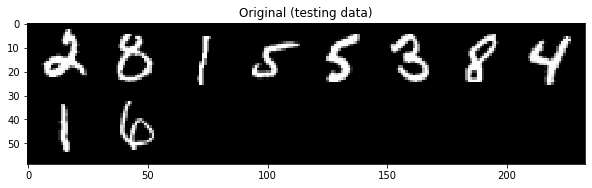

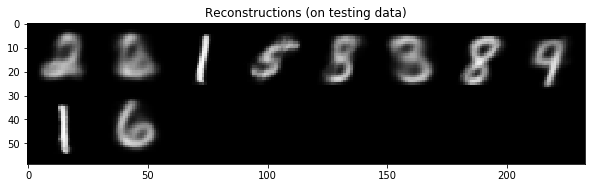

In [33]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

B = next(iter(test_loader))[0].to(device)
z, R = model(B)

plt.figure(figsize=(10,5))
show(make_grid(B[0:10,:,:,:].cpu(), padding=1))  
plt.title('Original (testing data)');

plt.figure(figsize=(10,5))
show(make_grid(R.view((128,1,28,28))[0:10,:,:,:].detach().cpu(), padding=1))     
plt.title('Reconstructions (on testing data)')

In [36]:
latents = []
model.eval()
for x, y in test_loader:
    with torch.no_grad():
        z, R = model(x)
        latents.append(z.detach().numpy())

In [39]:
X = torch.tensor(np.concatenate(latents),dtype=torch.float32)

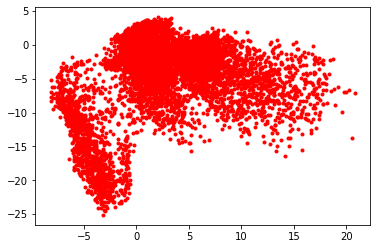

In [43]:
plt.plot(X[:,0].numpy(), X[:,1].numpy(),'r.')